In [5]:
# LangGraph Weather Report (Thailand)
# ตาม Spec: รายงานสภาพอากาศแต่ละจังหวัด ใช้งานผ่าน Gradio + LangGraph

import os
import time
from typing import Annotated
from dotenv import load_dotenv
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.tools import Tool
import gradio as gr

# จัดเต็มรายชื่อจังหวัดไทย (แบบย่อ)
THAI_PROVINCES = [
    "กรุงเทพมหานคร", "เชียงใหม่", "เชียงราย", "ขอนแก่น", "ชลบุรี",
    "นครราชสีมา", "นครศรีธรรมราช", "ภูเก็ต", "สงขลา", "สุราษฎร์ธานี",
    # ... (ต่อได้ตามต้องการ, ไม่ต้องใส่ครบทุกจังหวัดก็ได้)
]

load_dotenv(override=True)



True

In [2]:
# แบบ 03/02: สร้าง State Model ด้วย BaseModel + Annotated, ใช้ฟังก์ชัน add_value รวมค่าจาก state

def add_value(left, right):
    if right is not None:
        return right
    return left

class State(BaseModel):
    province: Annotated[str, add_value] = ""
    weather: Annotated[str, add_value] = ""  # raw string ข้อมูลอากาศ
    weather_html: Annotated[str, add_value] = ""
    html_timestamp: Annotated[float, add_value] = 0  # ใช้ timestamp seconds



In [6]:
# ใช้ MemorySaver สำหรับเช็ค/เก็บสถานะ province + html (ใน memory, แค่เดโม, จริงควรใช้ db หรือ file)

checkpointer = MemorySaver()
graph_builder = StateGraph(State)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# เตรียม Serper Tool สำหรับ Google Search
serper = GoogleSerperAPIWrapper()
tool_search = Tool(
    name="search",
    func=serper.run,
    description="ค้นหาข้อมูลสภาพอากาศจาก Google ภาษาไทย รายจังหวัดไทย"
)



In [7]:
# Node 1: ตรวจสอบว่าปัจจุบัน (province เดียวกัน) เคย gen HTML แล้วและยังไม่หมดอายุหรือไม่ (30 นาที)
# (State-graph จะวนมา node นี้เป็น node แรก)
def check_cache(state: State):
    CACHE_DURATION = 1800  # 30 นาที (วินาที)
    now = time.time()
    if state.weather_html and (now - state.html_timestamp <= CACHE_DURATION):
        return {"weather_html": state.weather_html, "html_timestamp": state.html_timestamp, "province": state.province, "weather": state.weather}
    return {"weather_html": "", "html_timestamp": 0, "province": state.province, "weather": ""}



In [8]:
# Node 2: ถ้ายังไม่มีข้อมูลหรือหมดอายุ —> ไป search ข้อมูลอากาศใหม่ (Serper+Google)
def fetch_weather(state: State):
    # ใช้ prompt ถามเป็นไทย เพื่อให้ Serper ติดต่อ Google แบบไทย
    query = f"สภาพอากาศวันนี้ จังหวัด{state.province}"
    result = tool_search.run(query)
    return {"weather": result}



In [9]:
# Node 3: LLM สรุป + สร้างรายงาน HTML ที่สวยงาม ให้เหมาะใช้แสดงผลบนเว็บ
# ถ้า LLM คืนมาพร้อม code fence ```html ... ``` ให้ลอกออกก่อนเก็บ
def build_html(state: State):
    def strip_code_fence(text: str) -> str:
        t = text.strip()
        if t.startswith("```"):
            lines = t.splitlines()
            # ตัดบรรทัดแรก (``` หรือ ```html)
            if lines and lines[0].startswith("```"):
                lines = lines[1:]
            # ตัดบรรทัดท้าย ถ้าเป็น ```
            if lines and lines[-1].strip() == "```":
                lines = lines[:-1]
            t = "\n".join(lines).strip()
        return t

    prompt = (
        "ให้สรุปข้อมูลสภาพอากาศรายวันที่ค้นหามา (ภาษาไทย) แล้วจัดรูปแบบเป็น HTML ที่ดูสวยงามและอ่านง่าย "
        "โดยควรมีหัวข้อชื่อจังหวัด วันที่ และเนื้อหาสรุปแบบกระชับใส่ใน <div> หรือ <section>. ให้ return เฉพาะ HTML เท่านั้น ไม่ต้องมีคำอธิบาย\n"
        f"ข้อมูลที่ได้ (raw): {state.weather}\n"
    )
    resp = llm.invoke(prompt)
    html = strip_code_fence(str(resp.content))
    timestamp = time.time()
    return {"weather_html": html, "html_timestamp": timestamp}



In [10]:
# Node 4: ส่งออก HTML ที่สรุปเรียบร้อย ใน state ปัจจุบัน
def output_html(state: State):
    # ส่งออก HTML, timestamp ล่าสุด
    return state



In [11]:
# Wire nodes/edges (รูปแบบคล้าย 03.ipynb)
graph_builder.add_node("check_cache", check_cache)
graph_builder.add_node("fetch_weather", fetch_weather)
graph_builder.add_node("build_html", build_html)
graph_builder.add_node("output_html", output_html)

graph_builder.add_edge(START, "check_cache")
# check_cache ถ้ายัง valid ข้ามไป output, ถ้าไม่ valid ต้อง fetch + สร้างใหม่
# ตรรกะจะวนโดยใช้ค่าที่ node return

def select_next_edge(state: State):
    if state.weather_html != "" and state.html_timestamp > 0:
        return "output_html"
    return "fetch_weather"

graph_builder.add_conditional_edges("check_cache", select_next_edge)  # custom conditional

graph_builder.add_edge("fetch_weather", "build_html")
graph_builder.add_edge("build_html", "output_html")
graph_builder.add_edge("output_html", END)

graph = graph_builder.compile(checkpointer=checkpointer)



In [ ]:
# ฟังก์ชันหลัก ใช้กับ Gradio Interface (province เลือก Dropdown) -> คืน HTML

def get_weather_report(province):
    def strip_code_fence(text: str) -> str:
        t = text.strip()
        if t.startswith("```"):
            lines = t.splitlines()
            if lines and lines[0].startswith("```"):
                lines = lines[1:]
            if lines and lines[-1].strip() == "```":
                lines = lines[:-1]
            t = "\n".join(lines).strip()
        return t

    initial_state = State(province=province)
    result_state = graph.invoke(initial_state, config={"configurable": {"thread_id": province}})  # thread_id ต่อจังหวัดเพื่อแยก cache
    return strip_code_fence(result_state["weather_html"])

 

In [13]:
# สร้าง Gradio Interface แบบเรียบง่าย ใช้ Dropdown (ตาม Spec)

with gr.Blocks() as demo:
    gr.Markdown("""# รายงานสภาพอากาศรายจังหวัด (ประเทศไทย)\nเลือกจังหวัดด้านล่างแล้วกดปุ่มเพื่อดูรายงาน""")
    province = gr.Dropdown(choices=THAI_PROVINCES, label="เลือกจังหวัด", value=THAI_PROVINCES[0])
    btn = gr.Button("แสดงรายงานสภาพอากาศ")
    html_report = gr.HTML(label="รายงานสภาพอากาศ", elem_id="weather-html")
    btn.click(fn=get_weather_report, inputs=province, outputs=html_report)

demo.launch()



* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


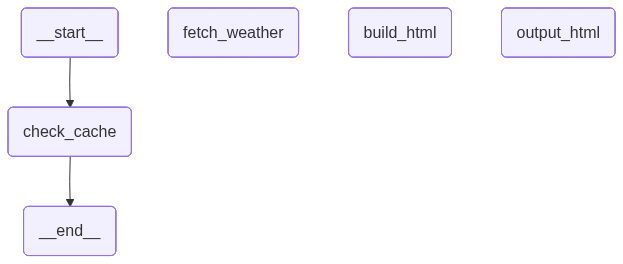

In [14]:
# แสดงแผนภาพกราฟควบคุม LangGraph (Optional)
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))
